# Imports
For this part of the hands on session, a few python package are required but they all can be installed simply using the command pip install

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf 
import lmfit # source: https://lmfit.github.io/lmfit-py/
from lmfit import minimize, Parameters, fit_report
from astropy.timeseries import LombScargle

np.random.seed(110)

# Hands on session Part II

This part of the lbl hands on session is about to play with a toy model to better understand the data produced by lbl and what is embebded in them.

Please note that this is a toy model so it is not represent the true lbl computations.

## Build a line template 

Every lbl computation are made compared to a template so let's build the template of one line. 

For this toy model, every line will be considered as gaussian lines (or skewed gaussian if you want to try a more complex model with assymetric lines) build using the following function:

In [2]:
def Gauss(x, a, sigma):
        return 1 - a * np.exp(-x**2 / (2 * sigma**2))


def skewed_gaussian(x, a, sigma, alpha) :
    def cdf(x) :
        return((1/2)*(1+erf(x/np.sqrt(2))))

    return 1 + (2/sigma)*(-a/2)*np.exp(-(x)**2 / (2 * sigma**2))*cdf(alpha*(x)/sigma)

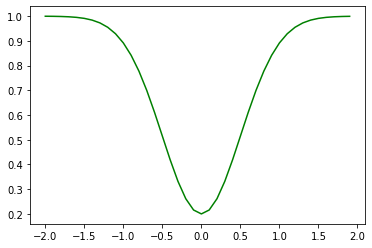

In [3]:
a_0 =  0.8      #set your line depth
sigma_0 =  0.5 #set your line width
x_0 = 0      #set your line x-shift 

x = np.arange(-2,2,1/10) 
Template = Gauss(x-x_0, a_0, sigma_0)

plt.plot(x, Template, "g")
plt.show()

## Build a line observation

So here is your template for that line. 

Then build one observation of that line by building another line with slightly different paramaters 

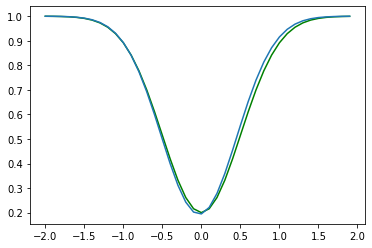

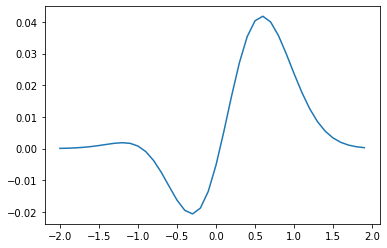

In [4]:
a_l =   a_0 + np.random.randn()/50       #set your line depth
sigma_l =  sigma_0 + np.random.randn()/50    #set your line width
x_l =  x_0 + np.random.randn()/50        #set your line x-shift

line = Gauss(x+x_l, a_l, sigma_l)

plt.plot(x, Template, "g")
plt.plot(x, line)
plt.show()

#lets plot the difference between the line and the template
plt.plot(x, line-Template)
plt.show()

## Compute the bouchy equation

lbl is using the Bouchy's framework (Bouchy et al. 2001): to simplify, the difference between the line observed $A$ and the template $A_0$ can be decomposed into a Taylor serie as following :

$A(i)-A_0(i) = d_0v + dv \frac{d A_0(i)}{d \lambda(i)} + d_2v \frac{d^2 A_0(i)}{d \lambda(i)^2} + d_3v \frac{d^3 A_0(i)}{d \lambda(i)^3} + \mathcal{O}(\frac{d^3 A_0(i)}{d \lambda(i)^3}) $

What lbl do is to compute $d_0v$, $dv$, $d_2v$, $d_3v$ ... In our model we will fit those parameters. 

Please note that this is a toy model so it is not represent the true lbl computations. For more details, please refer to Bouchy+01 and Artigau+22 or dig into the lbl code to see how it is truely computed. 

In [5]:
#bouchy equation to minimize 
def equation(params, d1, d2, d3, diff):
    d0v = params.get('d0v').value
    dv  = params.get('dv').value
    d2v = params.get('d2v').value
    d3v = params.get('d3v').value
    z = d0v + dv*d1 + d2v*d2 + d3v*d3 - diff
    return(z)

def fit_bouchy(line, Template): 

    #get difference between line and template
    diff_seg = line - Template
    
    #get Template Gradient
    d1 = np.gradient(Template, x) #first dervative
    d2 = np.gradient(d1, x)       #second dervative
    d3 = np.gradient(d2, x)       #second dervative
    
    #initialize
    params_ini = Parameters()
    params_ini.add('d0v', value=0, min=-np.inf, max=np.inf)
    params_ini.add('dv', value=0, min=-np.inf, max=np.inf)
    params_ini.add('d2v', value=0, min=-np.inf, max=np.inf)
    params_ini.add('d3v', value=0, min=-np.inf, max=np.inf)
    #fit
    out = minimize(equation, params_ini, args = (d1, d2, d3, diff_seg))
    
    return (out.params)

Parameters([('d0v', <Parameter 'd0v', value=0.005988474740334764 +/- 0.000753, bounds=[-inf:inf]>), ('dv', <Parameter 'dv', value=0.027276343319923638 +/- 0.0023, bounds=[-inf:inf]>), ('d2v', <Parameter 'd2v', value=-0.0036270413000724588 +/- 0.000597, bounds=[-inf:inf]>), ('d3v', <Parameter 'd3v', value=-0.00029856380658870626 +/- 0.000315, bounds=[-inf:inf]>)])


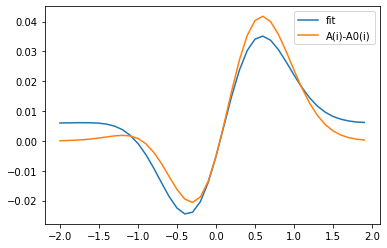

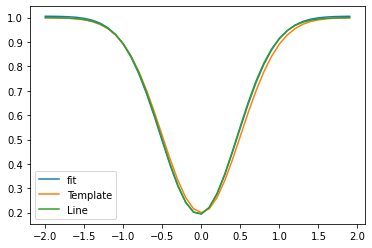

In [6]:
result = fit_bouchy(line, Template)
print(result)

plt.plot(x, equation(result, np.gradient(Template, x), np.gradient(np.gradient(Template, x), x), np.gradient(np.gradient(np.gradient(Template, x), x), x), line-Template)+line-Template, label='fit')
plt.plot(x, line-Template, label='A(i)-A0(i)')
plt.legend()
plt.show()

plt.plot(x, equation(result, np.gradient(Template, x), np.gradient(np.gradient(Template, x), x), np.gradient(np.gradient(np.gradient(Template, x), x), x), line-Template)+line, label='fit')
plt.plot(x, Template, label='Template')
plt.plot(x, line, label='Line')
plt.legend()
plt.show()